In [3]:
from src.datasets.floe import DatasetFloe_Ice_Mask, DatasetValidateFloe
from src.models.dsc.dsc_unet import UNetDSC, SmallUNetDSC
import matplotlib.pyplot as plt
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC, LargeAxialLBC
import torch
import numpy as np
import os
from torch import nn
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
import torch.nn.functional as F

In [8]:
def eval_model(model: nn.Module, checkpoint_path: str, title: str) -> None:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.train()
    out = nn.Softmax(dim=1)

    mask_list, pred_list = [], []

    img = val_set[IMG_NUMBER]['image'].to(device=device).unsqueeze(0)[:, 0, :, :].unsqueeze(1)
    mask = val_set[IMG_NUMBER]['mask'].to(device=device, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        output = model(img)
    sftmx = out(output)
    argmx = torch.argmax(sftmx, dim=1)

    hist = _fast_hist(mask.squeeze(0).squeeze(0), argmx.squeeze(0).to(dtype=torch.long), 2)
    iou = jaccard_index(hist)[0]
    acc = per_class_pixel_accuracy(hist)[0]
    loss = F.cross_entropy(output, mask.squeeze(1)).detach().item()
    
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    img_np = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    axs[0].imshow(img_np[:, :, 0])
    mask_np = mask.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    axs[1].imshow(mask_np)
    argmx_np = argmx.permute(1, 2, 0).detach().cpu().numpy()
    axs[2].imshow(argmx_np)
    sftmx_np = sftmx.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    axs[3].imshow(sftmx_np[:, :, 1])
#     axs[3].hist(sftmx_np[:, :, 1])
    fig.suptitle(title + f"\n acc: {acc:.2f}, iou: {iou:.2f}, loss: {loss:.2f}");

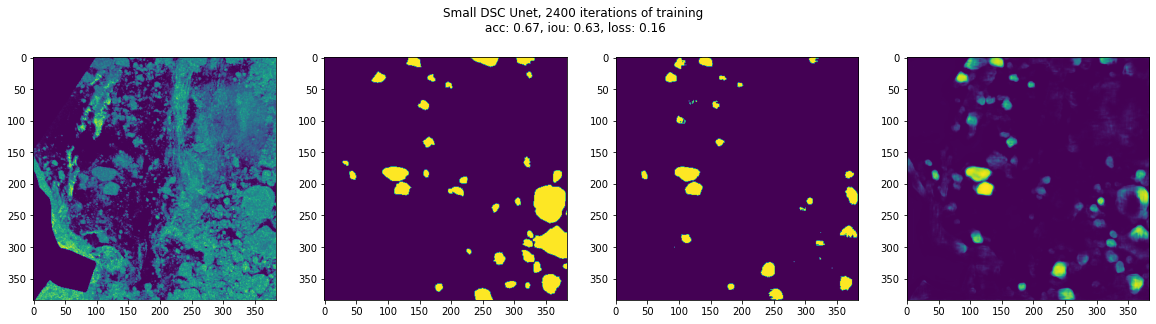

In [34]:
device = 'cpu'  # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_NUMBER = 4

val_set = DatasetValidateFloe()

eval_model(
    SmallUNetDSC(n_channels=1, n_classes=2, bilinear=True).to(device), 
    '/home/dsola/repos/PGA-Net/src/checkpoints/epoch2.pth', 
    'Small DSC Unet, 2400 iterations of training'
)